In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"E:\edge download\UserBehavior.csv\UserBehavior.csv",engine='c',chunksize=10000000)
df = df.get_chunk(10000000) # 读取迭代器中10000000条数据
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [3]:
df.columns = ['用户ID','商品ID','商品类目ID','行为类型','时间戳']
print(df.columns)
print(df.head())
print(df.info())

Index(['用户ID', '商品ID', '商品类目ID', '行为类型', '时间戳'], dtype='object')
   用户ID     商品ID   商品类目ID 行为类型         时间戳
0     1  2333346  2520771   pv  1511561733
1     1  2576651   149192   pv  1511572885
2     1  3830808  4181361   pv  1511593493
3     1  4365585  2520377   pv  1511596146
4     1  4606018  2735466   pv  1511616481
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   用户ID    int64 
 1   商品ID    int64 
 2   商品类目ID  int64 
 3   行为类型    object
 4   时间戳     int64 
dtypes: int64(4), object(1)
memory usage: 381.5+ MB
None


In [4]:
print(type(df['行为类型'].loc[0]))
print(type(df['时间戳'].loc[0]))

<class 'str'>
<class 'numpy.int64'>


In [5]:
from collections import Counter
print(Counter(df['行为类型']))

Counter({'pv': 8950064, 'cart': 559132, 'fav': 291657, 'buy': 199147})


In [6]:
import datetime
# 时区转换to_datetime的默认时区不是中国,所以要加8小时
df['时间'] = pd.to_datetime(df['时间戳'],unit='s') + pd.Timedelta(hours=8)

# 保留2017.11.25-2017.12.3期间的数据
startTime = datetime.datetime.strptime("2017-11-25 00:00:00","%Y-%m-%d %H:%M:%S")
endTime = datetime.datetime.strptime("2017-12-03 00:00:00","%Y-%m-%d %H:%M:%S")

df = df[(df['时间'] >= startTime) & (df['时间'] <= endTime)]
df = df.reset_index(drop=True)

# 按照日期和小时进行时间拆分
df['日期'] = df['时间'].dt.date
df['小时'] = df['时间'].dt.hour

# 删除时间戳节约内存
df.drop('时间戳', inplace=True, axis=1)

#print(df['时间'].dtype)

In [7]:
#print(df.head())
# 使默认以HTML表格形式显示
from IPython.display import display
display(df.head()) 

,用户ID,商品ID,商品类目ID,行为类型,时间,日期,小时
0,1,2333346,2520771,pv,2017-11-25 06:15:33,2017-11-25,6
1,1,2576651,149192,pv,2017-11-25 09:21:25,2017-11-25,9
2,1,3830808,4181361,pv,2017-11-25 15:04:53,2017-11-25,15
3,1,4365585,2520377,pv,2017-11-25 15:49:06,2017-11-25,15
4,1,4606018,2735466,pv,2017-11-25 21:28:01,2017-11-25,21


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8624867 entries, 0 to 8624866
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   用户ID    int64         
 1   商品ID    int64         
 2   商品类目ID  int64         
 3   行为类型    object        
 4   时间      datetime64[ns]
 5   日期      object        
 6   小时      int32         
dtypes: datetime64[ns](1), int32(1), int64(3), object(2)
memory usage: 427.7+ MB
None


In [9]:
# 数据分析
total_unique_userID = df['用户ID'].nunique()
total_unique_goodsID = df['商品ID'].nunique()
total_unique_categoriesID = df['商品类目ID'].nunique()
user_bought_count = df[df['行为类型'] == 'buy']['用户ID'].nunique()
user_notbought_count = total_unique_userID - user_bought_count

In [10]:
print(f"          UV：{total_unique_userID}")
print(f"      商品数：{total_unique_goodsID}")
print(f"      类目数：{total_unique_categoriesID}")
print(f"  付费用户数：{user_bought_count}")
print(f"付费用户占比：{user_bought_count/total_unique_userID*100:.2f}%")

          UV：97810
      商品数：1449081
      类目数：7840
  付费用户数：62127
付费用户占比：63.52%


In [11]:
types_counts = df['行为类型'].value_counts()
print(types_counts)

行为类型
pv      7718687
cart     480744
fav      251931
buy      173505
Name: count, dtype: int64


In [12]:
print(types_counts.index)

Index(['pv', 'cart', 'fav', 'buy'], dtype='object', name='行为类型')


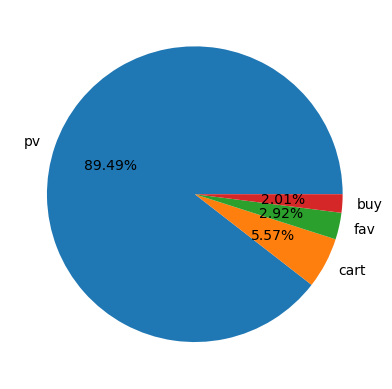

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.pie(x=types_counts,labels=types_counts.index,autopct='%1.2f%%')
plt.show()

In [14]:
type_df = pd.DataFrame([types_counts,types_counts/9,types_counts/total_unique_userID],
                       index=['total','avg_days','avg_users'])
# 取消科学计数法，保留两位小数
pd.set_option('display.float_format', '{:.2f}'.format)

# 付费用户行为记录
type_df.loc['paying_user'] = df[df['用户ID'].isin(df[df['行为类型']=='buy']['用户ID'])]['行为类型'].value_counts() # 找到行为类型有过buy的行(进行过buy操作的用户ID的行)，再提取行为类型记录各类型的值
display(type_df)

行为类型,pv,cart,fav,buy
total,7718687.00,480744.00,251931.00,173505.00
avg_days,857631.89,53416.00,27992.33,19278.33
avg_users,78.92,4.92,2.58,1.77
paying_user,5513421.00,358369.00,175219.00,173505.00


In [15]:
# 跳失率和复购率
# 跳失率=只有点击行为的用户/总用户数 （其实真正的跳失率应该是：只浏览一个页面就离开的访问次数 / 该页面的全部访问次数。这边只是为了突出这些有待发展的客户）

# 复购率=购买2次及以上用户数/总购买用户数,复购率可以分为按客户计算和按交易计算,一定要确定统计周期
'''a = df[df['行为类型'] == 'pv']['用户ID'].nunique()/total_unique_userID
print(a)'''

groupby_userID = df.groupby(by='用户ID')
#print(groupby_userID['行为类型'].value_counts().head())
user_type = groupby_userID['行为类型'].value_counts().unstack() # unstack() 将多级索引的"长格式"数据转换为"宽格式"表格 将第二级索引（type）变为列名

In [16]:
print(user_type.tail())

行为类型     buy  cart  fav     pv
用户ID                          
1017990  NaN  3.00  NaN  48.00
1017994  NaN  2.00 3.00   9.00
1017997 2.00   NaN 3.00  80.00
1018000  NaN  4.00  NaN 158.00
1018011 1.00   NaN  NaN  33.00


In [17]:
# sum(axis=1)对DataFrame进行横向相加，如果一个userid的pv值==横向相加的和，那就表明他只有点击行为
only_pv_users = user_type[user_type['pv']==user_type.sum(axis=1)]
# 计算跳失率
bounce_rate = only_pv_users.shape[0]/total_unique_userID
print("跳失率:{:.2f}%".format(bounce_rate*100))
# 跳失率一定程度上反映了商品的受欢迎程度,跳失率越低证明只有点击行为的用户越少

跳失率:7.75%


复购率:62.57%


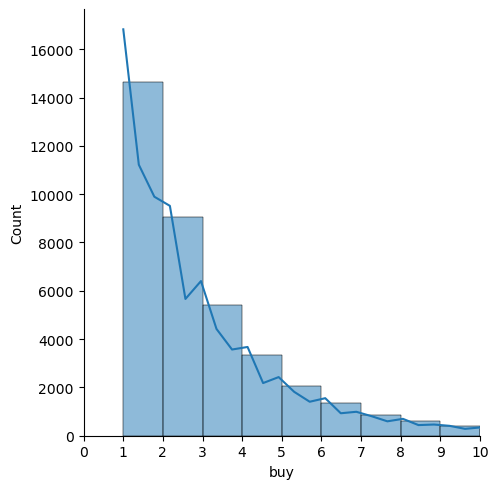

复购次数低于10次的用户占复购用户次数的占比:97.13%


In [18]:
# 复购率
repurchase_users = user_type[user_type['buy']>=2].shape[0]  # 购买记录超过1次的用户数
repurchase_rate = repurchase_users/user_bought_count
print("复购率:{:.2f}%".format(repurchase_rate*100))

# 进一步分析复购次数
import seaborn as sns
sns.displot(user_type[user_type['buy']>=2]['buy']-1,binwidth=1.0,kde=True) # kde参数，在直方图基础上添加一条平滑的密度曲线,更直观地显示数据的概率分布形状
plt.xlim((0,10))
plt.xticks([i for i in range(11)])
plt.show()

low_repurchase_rate = user_type[(user_type['buy']>=2) & (user_type['buy'] <= 10)].shape[0] / user_type[user_type['buy']>=2].shape[0]
print(f"复购次数低于10次的用户占复购用户次数的占比:{low_repurchase_rate:.2%}")
# 多次复购用户极少,淘宝用户量庞大，复购次数少的用户拉高了复购率，淘宝应该提高服务质量或商品质量，增加用户复购次数，将用户发展为长期用户

In [19]:
pv_df = df[df['行为类型']=='pv']
buy_df = df[df['行为类型']=='buy']
cart_df = df[df['行为类型']=='cart']
fav_df = df[df['行为类型']=='fav']

In [20]:
# process1 点击->加购->购买
pv_cart_df = pd.merge(left=pv_df,right=cart_df,how='inner',on=['用户ID','商品ID','商品类目ID'],suffixes=('_pv','_cart'))
# print(pv_cart_df.head())
cart_buy_df = pd.merge(left=cart_df,right=buy_df,how='inner',on=['用户ID','商品ID','商品类目ID'],suffixes=('_cart','_buy'))
count_users_pv_cart = pv_cart_df[pv_cart_df['时间_pv'] < pv_cart_df['时间_cart']]['用户ID'].nunique() # 有先点击后再放入购物车的行为的用户一共有多少个，下面同理
count_users_cart_buy = cart_buy_df[cart_buy_df['时间_cart'] < cart_buy_df['时间_buy']]['用户ID'].nunique()

# process2 点击->收藏->购买
pv_fav_df = pd.merge(left=pv_df,right=fav_df,how='inner',on=['用户ID','商品ID','商品类目ID'],suffixes=('_pv','_fav'))
fav_buy_df = pd.merge(left=fav_df,right=buy_df,how='inner',on=['用户ID','商品ID','商品类目ID'],suffixes=('_fav','_buy'))
count_users_pv_fav = pv_fav_df[pv_fav_df['时间_pv'] < pv_fav_df['时间_fav']]['用户ID'].nunique()
count_users_fav_buy = fav_buy_df[fav_buy_df['时间_fav'] < fav_buy_df['时间_buy']]['用户ID'].nunique()

fav_cart_ratio = (count_users_pv_fav+count_users_pv_cart)/total_unique_userID
buy_ratio=(count_users_fav_buy+count_users_cart_buy)/total_unique_userID

print('收藏加购用户转化率为:%.2f%%'%(fav_cart_ratio*100))
print('购买用户转化率为:%.2f%%'%(buy_ratio*100))

收藏加购用户转化率为:52.91%
购买用户转化率为:27.13%


两者之间转化率有差距，可能是商品广告界面较为吸引，但后继吸引力不足，比如评论区呈现的差评

In [36]:
from pyecharts.charts import Funnel
from pyecharts import options as opts

In [39]:
# 漏斗图
process_data_pair = [("点击量", total_unique_userID), 
                     ("收藏加购量", count_users_pv_fav+count_users_pv_cart),
                     ("购买量", count_users_fav_buy+count_users_cart_buy)]
funnel = (
            Funnel(init_opts=opts.InitOpts(width='500px', height='400px'))
            .add("type", 
             data_pair=process_data_pair, 
             label_opts=opts.LabelOpts(position="inside"),
             gap=2,
             tooltip_opts=opts.TooltipOpts(is_show=True))
            .set_global_opts(title_opts=opts.TitleOpts(title="用户转化率", subtitle="process 浏览->收藏/加购->购买",))
            .render("funnel_base.html")
            )
# 生成了html文件在当前目录

In [47]:
data_with_rate = []
for i, (name, value) in enumerate(process_data_pair):
    if i == 0:
        # 第一个阶段没有前一个阶段，显示为100%或空
        rate = 100  # 或者可以设置为None不显示
    else:
        prev_value = process_data_pair[i-1][1]
        if prev_value > 0:
            rate = round((value / prev_value) * 100, 2)
        else:
            rate = 0
    
    # 将数据和转化率组合
    data_with_rate.append({
        "name": f"{name}\n转化率: {rate}%" if i > 0 else name,
        "value": value
    })

funnel = (
    Funnel(init_opts=opts.InitOpts())
    .add(
        "type", 
        data_pair=[(item["name"], item["value"]) for item in data_with_rate],
        label_opts=opts.LabelOpts(
            position="inside",
            font_size=12
        ),
        gap=2,
        tooltip_opts=opts.TooltipOpts(
            is_show=True,
            formatter="{a} <br/>{b} : {c} ({d}%)"
        )
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="用户转化率", 
            subtitle="process 浏览->收藏/加购->购买",
            item_gap=15
                                ),
        legend_opts=opts.LegendOpts(
            pos_left = 200
                                    )
                    )
    .render("funnel_base.html")
)

In [21]:
behavior_types = list(types_counts.index)
print(behavior_types)

['pv', 'cart', 'fav', 'buy']


In [22]:
groupby_date = df.groupby(by='日期') # 根据日期分组
dates = df['日期'].unique()
dates_df = pd.DataFrame(data=None, index=dates, columns=behavior_types)

for d in dates:
    dates_df.loc[d] = groupby_date.get_group(d)['行为类型'].value_counts()
# 日期转换为星期，datetime.datetime.isoweekday（）返回的1-7代表周一--周日
dates_df['weekday'] = [datetime.datetime.isoweekday(datetime.date(x.year,x.month,x.day)) for x in dates_df.index]
display(dates_df.head())

,pv,cart,fav,buy,weekday
2017-11-25,931879,56283,30168,19719,6
2017-11-26,952269,59469,31281,20211,7
2017-11-27,897421,55010,29723,22225,1
2017-11-28,883696,54194,29002,20996,2
2017-11-29,913154,55802,30030,21814,3


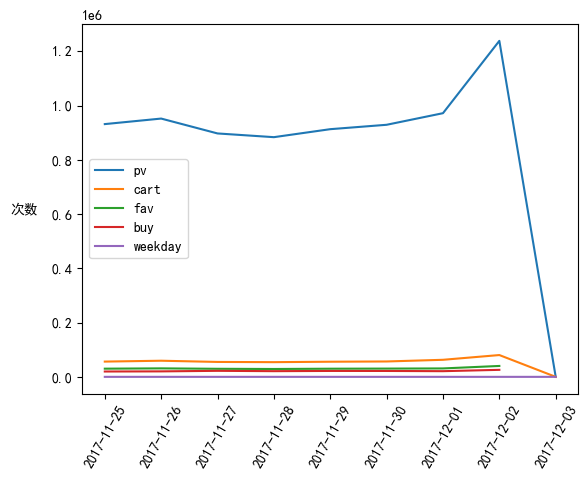

In [23]:
plt.rcParams['font.sans-serif'] = 'SimHei'
dates_df.plot()
plt.xticks(rotation=60)
plt.ylabel('次数',rotation=0,va='center',labelpad=20) # va='center'将标签放在中心，labelpad调整标签距离坐标轴的距离，越大距离越远
plt.show()
# pv数值过大，影响数值较小的数据可视化

In [24]:
xaxis_data = [f"{date} {weekday}" for date, weekday in zip(dates_df.index, dates_df['weekday'])]
print(xaxis_data)

['2017-11-25 6', '2017-11-26 7', '2017-11-27 1', '2017-11-28 2', '2017-11-29 3', '2017-11-30 4', '2017-12-01 5', '2017-12-02 6', '2017-12-03 7']


In [33]:
from pyecharts.charts import Line

In [112]:
# 使用pyecharts进行数据可视化与实现可交互
Lines = (
    Line(init_opts=opts.InitOpts(width="800px", height="500px"))
    .add_xaxis(xaxis_data=xaxis_data)
    .add_yaxis("pv", y_axis=dates_df['pv'],is_symbol_show=False)
    .add_yaxis("cart",y_axis=dates_df['cart'],is_symbol_show=False)
    .add_yaxis("fav",y_axis=dates_df['fav'],is_symbol_show=False)
    .add_yaxis("buy",y_axis=dates_df['buy'],is_symbol_show=False)
    .add_yaxis("ops",y_axis=groupby_date['用户ID'].count(),is_symbol_show=False)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="用户行为变化趋势图", 
                                  subtitle="2017/11/25-2017/12/03期间用户行为变化趋势"),
        tooltip_opts=opts.TooltipOpts(trigger='axis'),
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        xaxis_opts=opts.AxisOpts(type_='category', boundary_gap=False))
    .render("Lines.html")
)

In [25]:
groupby_hour = df.groupby(by='小时')                                         # 根据时段分组
hours = [x for x in range(0, 24)]
hours_df = pd.DataFrame(data=None, index=hours, columns=behavior_types)

for h in hours:
    hours_df.loc[h] = groupby_hour.get_group(h)['行为类型'].value_counts()

hours_df['uv'] = [groupby_hour.get_group(hour)['用户ID'].nunique() for hour in hours]  # 独立访客量
display(hours_df.head())

,pv,cart,fav,buy,uv
0,250006,15245,8723,4711,27590
1,115337,7075,4091,1832,14045
2,63497,3821,2279,1027,8292
3,44019,2746,1736,598,5969
4,37692,2311,1349,524,5424


In [104]:
Lines2 = (
    Line(init_opts=opts.InitOpts(width="800px", height="500px"))
    .add_xaxis(xaxis_data=hours_df.index)
    .add_yaxis("pv", y_axis=hours_df['pv'],is_symbol_show=False)
    .add_yaxis("cart",y_axis=hours_df['cart'],is_symbol_show=False)
    .add_yaxis("fav",y_axis=hours_df['fav'],is_symbol_show=False)
    .add_yaxis("buy",y_axis=hours_df['buy'],is_symbol_show=False)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="用户行为时段分布图", 
                                  subtitle="用户行为的时段分布情况"),
        tooltip_opts=opts.TooltipOpts(trigger='axis'),
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        xaxis_opts=opts.AxisOpts(type_='category', boundary_gap=False))
    .render("Lines2.html")
)

In [29]:
'''import psutil

内存信息 = psutil.virtual_memory()
print(f"可用内存: {内存信息.available / (1024**3):.2f} GB")
print(f"内存使用率: {内存信息.percent}%")'''

可用内存: 7.43 GB
内存使用率: 51.2%


In [28]:
#print((groupby_date.get_group(datetime.date(2017, 11, 25)).groupby(by='用户ID').size() > active_user_standard).value_counts())
print((groupby_date.get_group(datetime.date(2017, 11, 25)).groupby(by='用户ID').size() > active_user_standard).value_counts()[True])

# 下面两句更为高效
# xs 方法是 pandas 中用于从多级索引(MultiIndex)对象中提取特定交叉部分(cross-section)的方法。它特别适用于处理具有层次化索引的数据。
grouped_size = df.groupby(by=['日期','用户ID']).size()
print(grouped_size)
print((grouped_size.xs(datetime.date(2017, 11, 25), level='日期') > active_user_standard).value_counts()[True]) 

42766
日期          用户ID   
2017-11-25  1           5
            19         11
            21         56
            27         20
            42         14
                       ..
2017-12-03  390401      1
            412538      1
            465103      1
            528650      1
            1014530     1
Length: 594421, dtype: int64
42766


In [30]:
print("2017-12-03 所有记录:", len(df[df['日期'].astype(str)=='2017-12-03']))

2017-12-03 所有记录: 24


In [128]:
print(df[(df['行为类型']=='buy') & (df['日期']==datetime.date(2017, 12, 3))])
#print(df[(df['行为类型']=='buy') & (df['时间']==datetime.datetime('2017-12-3'))])
#print(df[df['行为类型']=='buy'].groupby(by=['日期','用户ID']).size().groupby(level=0).count())

Empty DataFrame
Columns: [用户ID, 商品ID, 商品类目ID, 行为类型, 时间, 日期, 小时]
Index: []


In [31]:
dates_df['uv'] = [groupby_date.get_group(date)['用户ID'].nunique() for date in dates] 

# 当天使用淘宝app进行5此操作及以上的用户算作活跃用户
active_user_standard = 5

# dates_df['dau'] = [(groupby_date.get_group(d).groupby(by='用户ID').size() > active_user_standard).value_counts().get(True,0) for d in dates]
dates_df['dau'] = [(grouped_size.xs(d,level='日期') > active_user_standard).value_counts().get(True,0) for d in dates]
dates_df['au_rate'] = dates_df['dau']/dates_df['uv']                          # 活跃用户比例
dates_df['buyer'] = df[df['行为类型']=='buy'].groupby(by='日期')['用户ID'].size().astype(int)
dates_df['buyer_rate'] = dates_df['buyer']/dates_df['uv']                     # 付费用户比例
dates_df['ARPU'] = dates_df['buy']/dates_df['uv']                             # 人均购买量=总交易量/当日UV
dates_df['ARPPU'] = dates_df['buy']/dates_df['buyer']                         # 付费用户人均购买量

dates_df = dates_df.fillna(0)
dates_df

C:\Users\LJ\AppData\Local\Temp\ipykernel_10548\1567381733.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dates_df = dates_df.fillna(0)


,pv,cart,fav,buy,weekday,uv,dau,au_rate,buyer,buyer_rate,ARPU,ARPPU
2017-11-25,931879.00,56283.00,30168,19719,6,69932,42766,0.61,19719.00,0.28,0.28,1.00
2017-11-26,952269.00,59469.00,31281,20211,7,70851,44054,0.62,20211.00,0.29,0.29,1.00
2017-11-27,897421.00,55010.00,29723,22225,1,70215,42860,0.61,22225.00,0.32,0.32,1.00
2017-11-28,883696.00,54194.00,29002,20996,2,70304,42486,0.60,20996.00,0.30,0.30,1.00
2017-11-29,913154.00,55802.00,30030,21814,3,71298,43800,0.61,21814.00,0.31,0.31,1.00
2017-11-30,929352.00,56722.00,30469,21731,4,72459,44411,0.61,21731.00,0.30,0.30,1.00
2017-12-01,972109.00,62885.00,31048,20941,5,73266,45436,0.62,20941.00,0.29,0.29,1.00
2017-12-02,1238785.00,80377.00,40210,25868,6,96072,57509,0.60,25868.00,0.27,0.27,1.00
2017-12-03,22.00,2.00,0,0,7,24,0,0.00,0.00,0.00,0.00,0.00


In [39]:
(
    Line(init_opts = opts.InitOpts(width="800px",height="500px"))
    .add_xaxis(xaxis_data = dates_df.index)
    .add_yaxis("uv",y_axis = dates_df["uv"],is_symbol_show = False) #is_symbol_show=False: 不显示数据点的符号标记，只显示平滑的折线
    .add_yaxis("dau",y_axis = dates_df["dau"],is_symbol_show = False)
    .add_yaxis("buyer",y_axis = dates_df["buyer"],is_symbol_show = False)
    .set_global_opts(
        title_opts = opts.TitleOpts(title = "用户量变化趋势",
                                    subtitle = "2017/11/25-2017/12/03期间用户量变化趋势"),
        tooltip_opts = opts.TooltipOpts(trigger = 'axis'),
        toolbox_opts = opts.ToolboxOpts(is_show = True),
        xaxis_opts = opts.AxisOpts(type_='category',boundary_gap = False)
                    )
).render('Line4.html')

'E:\\computer science\\JupyterNotebook\\kaggle\\Line4.html'

In [64]:
# 使用RFM模型进行分析用户数据
groupby_buy_userid = df[df['行为类型'] == 'buy'].groupby(by='用户ID')
#print(groupby_buy_userid.groups.keys())

RF = pd.DataFrame(index=groupby_buy_userid.groups.keys(),columns=['R','F'])

RF['F'] = groupby_buy_userid['行为类型'].count()
RF['last_buy_time'] = groupby_buy_userid['时间'].max()

# 设2017-12-04为基点，分析客户最近一次交易时间间隔，即R
RF['R'] = (pd.to_datetime('2017-12-04') - RF['last_buy_time']).dt.days
print(RF.head())

     R   F       last_buy_time
27   2   2 2017-12-01 16:56:00
43   1   5 2017-12-02 11:48:42
100  5   8 2017-11-28 09:51:17
117  5  10 2017-11-28 16:09:39
119  4   3 2017-11-29 20:43:31


In [65]:
RF[['R','F']].describe()

,R,F
count,62127.00,62127.00
mean,3.35,2.79
std,2.19,2.68
min,1.00,1.00
25%,1.00,1.00
50%,3.00,2.00
75%,5.00,3.00
max,9.00,80.00


In [66]:
def R_score(x):
    if 0 <= x <= 1:
        return 4
    elif 2 <= x <= 3:
        return 3
    elif 4 <= x <= 6:
        return 2
    elif 7 <= x <= 9:
        return 1
    else:
        return 0


def F_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    elif x >= 4:
        return 4
    else:
        return 0


# 根据R,F进行评分
RF['R_score'] = RF['R'].map(R_score)
RF['F_score'] = RF['F'].map(F_score)

In [67]:
RF['R>mean?']=(RF['R_score']>RF['R_score'].mean())*1
RF['F>mean?']=(RF['F_score']>RF['F_score'].mean())*1

In [73]:
def user_classfication(df):
    R_score, F_score = df
    if R_score == 0 and F_score == 1:
        return "重要保持客户"
    elif R_score == 1 and F_score == 0:
        return "重要发展客户"
    elif R_score == 1 and F_score == 1:
        return "重要价值客户"
    elif R_score == 0 and F_score == 0:
        return "重要挽留客户"
    else:
        return None
RF['user_classification'] = RF[['R>mean?','F>mean?']].apply(user_classfication, axis=1)
RF.drop((['R>mean?','F>mean?']),inplace=True,axis=1)

In [74]:
display(RF.head())

,R,F,last_buy_time,R_score,F_score,user_classification
27,2,2,2017-12-01 16:56:00,3,2,重要发展客户
43,1,5,2017-12-02 11:48:42,4,4,重要价值客户
100,5,8,2017-11-28 09:51:17,2,4,重要保持客户
117,5,10,2017-11-28 16:09:39,2,4,重要保持客户
119,4,3,2017-11-29 20:43:31,2,3,重要保持客户


In [75]:
# 统计用户分类情况
print(RF['user_classification'].value_counts())
#print(RF['R'].value_counts())

user_classification
重要挽留客户    19525
重要发展客户    18376
重要价值客户    18239
重要保持客户     5987
Name: count, dtype: int64
R
1    17395
2    10374
3     8846
4     7170
5     5836
6     5123
7     4050
8     3332
9        1
Name: count, dtype: int64


In [87]:
percentages = ((RF['user_classification']
               .value_counts(normalize=True) * 100)
               .apply(lambda x: f"{x:.2f}%"))
print(percentages)

user_classification
重要挽留客户    31.43%
重要发展客户    29.58%
重要价值客户    29.36%
重要保持客户     9.64%
Name: proportion, dtype: object


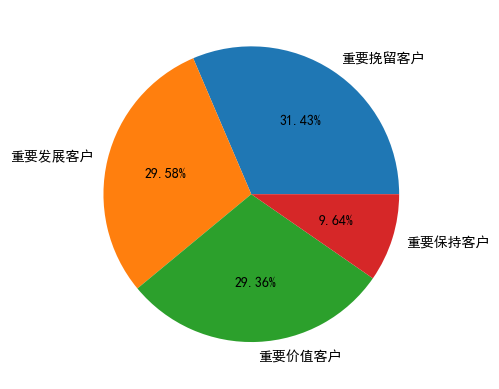

In [99]:
plt.pie(x = RF['user_classification'].value_counts(),labels=RF['user_classification'].value_counts().index,autopct='%.2f%%')
plt.show()

In [ ]:
应针对各类型客户推出合理的营销或挽留手段，以保持客户量

In [ ]:
商品数据分析

In [105]:
groupby_itemid = df.groupby(by='商品ID')
item_type_df = groupby_itemid['行为类型'].value_counts().unstack()
item_type_df.replace(to_replace=np.nan,value=0,inplace=True)
item_type_df = item_type_df.sort_values(by='buy',ascending=False)
item_type_df['buy_pv_conversion_rate'] = item_type_df['buy']/item_type_df['pv']
print(item_type_df.head(10))

行为类型       buy   cart   fav      pv  buy_pv_conversion_rate
商品ID                                                       
3122135 133.00  32.00 20.00  165.00                    0.81
3031354  72.00 165.00 43.00 1617.00                    0.04
2964774  65.00  65.00 13.00  616.00                    0.11
1910706  63.00   9.00  4.00  136.00                    0.46
1116492  59.00  15.00  2.00   86.00                    0.69
2560262  54.00 115.00 25.00  955.00                    0.06
3964583  50.00  60.00  8.00  421.00                    0.12
1415828  50.00  52.00  3.00  235.00                    0.21
3189426  48.00  37.00  5.00  342.00                    0.14
3237415  48.00  22.00  6.00  300.00                    0.16


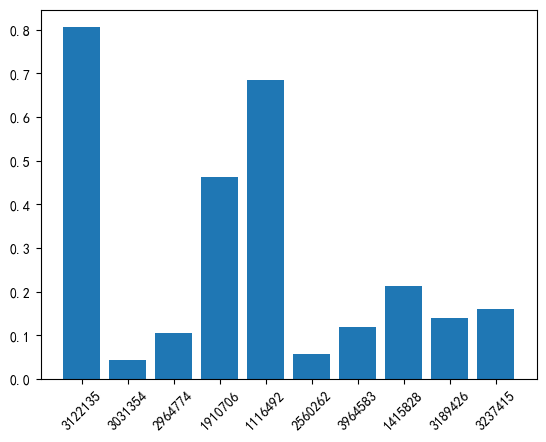

In [125]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.bar(item_type_df.head(10).index.astype(str),item_type_df.head(10)['buy_pv_conversion_rate'])
plt.xticks(rotation=45)
plt.show()

In [113]:
groupby_categoryid = df.groupby(by='商品类目ID')
category_type_df = groupby_categoryid['行为类型'].value_counts().unstack()
category_type_df.replace(to_replace=np.nan, value=0, inplace=True)
category_type_df = category_type_df.sort_values(by='buy', ascending=False)
category_type_df['buy_pv_conversion_rate'] = category_type_df['buy']/category_type_df['pv']
display(category_type_df.head(10))

行为类型,buy,cart,fav,pv,buy_pv_conversion_rate
商品类目ID,,,,,
1464116,3106.00,5437.00,2389.00,61416.00,0.05
2735466,3088.00,8623.00,3306.00,100773.00,0.03
4145813,2922.00,15732.00,9913.00,283461.00,0.01
2885642,2670.00,4980.00,2734.00,81726.00,0.03
4756105,2543.00,20490.00,12993.00,417374.00,0.01
4801426,2299.00,10724.00,6130.00,163566.00,0.01
982926,2168.00,13717.00,7825.00,247391.00,0.01
2640118,1608.00,5459.00,1445.00,64190.00,0.03
3002561,1512.00,7215.00,4827.00,123945.00,0.01


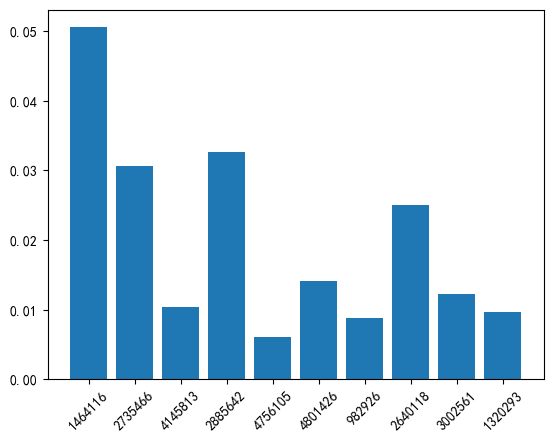

In [126]:
plt.bar(category_type_df.head(10).index.astype(str),category_type_df.head(10)['buy_pv_conversion_rate'])
plt.xticks(rotation=45)
plt.show()

In [129]:
# 帕累托原则 80%的销售额来自20%的商品 进行帕累托分析之前一定要先排序！！！！！并且为降序排序
category_type_df['cumsum'] = category_type_df['buy'].cumsum()

key = category_type_df['buy'].sum()*0.8
category_type_df['class'] = category_type_df['cumsum'].map(lambda x: 'up_80' if x<=key else 'down_20' )

print(category_type_df['class'].value_counts(normalize=True))

class
down_20   0.92
up_80     0.08
Name: proportion, dtype: float64
